In [1]:
@show Threads.nthreads()
@assert Threads.nthreads() > 1

Threads.nthreads() = 6


# Exercise: Parallel Monte Carlo (Threads)

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

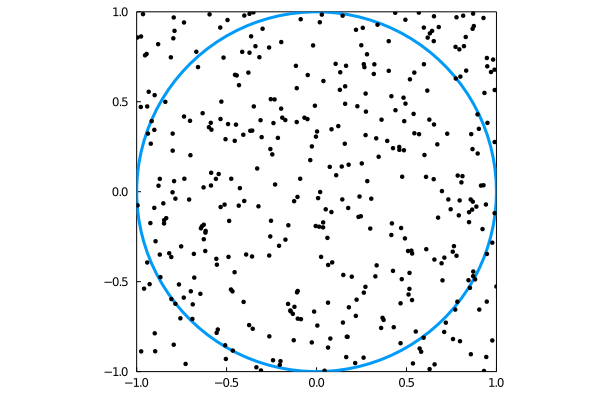

In [3]:
ENV["GKS_ENCODING"]="utf-8"
using Plots, Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1,1), ylims=(-1,1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Tasks

1. Write a function `compute_pi(N::Int)` which computes $\pi$ by throwing $N$ darts as described above. (you can copy the code from the distributed exercise)


2. Based on 1), write a function `compute_pi_parallel(N::Int)` which does the same but divides the work among `Threads.nthreads()` threads.


3. Benchmark and compare the methods from 1) and 2).


4. Write a function `compute_pi_multiple(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The function should be serial and based on 1). (you can copy the code from the distributed exercise)


5. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which does the same but in parallel. The function should also be based on 1).


6. Benchmark and compare the methods from 4) and 5).


7. Calculate $\pi$ estimates for `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.


8. Bonus: Write a function `compute_pi_multiple_double_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The calculation should be as parallel as possible. Multiple different values of $N$ should be calculated at the same time and every one of those calculations should be parallel as well.

A reasonable value could be `N = 10_000_000`.

In [4]:
using BenchmarkTools, LinearAlgebra

In [41]:
# 1) + 3)
function compute_pi(N::Int)
    M = 0 # number of darts that landed in the circle
    for i = 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end

    return 4*M / N  
end

@btime compute_pi(10_000_000)

  68.377 ms (0 allocations: 0 bytes)


3.1413864

In [42]:
# 2) + 3)

function compute_pi_parallel_threads(N::Int)
    nt = Threads.nthreads()
    pis = zeros(nt)
    Threads.@threads for i in 1:nt
        pis[Threads.threadid()] += compute_pi(ceil(Int, N / nt))
    end
    return sum(pis) / nt  # average value
end



tmap(f, itr) = map(fetch, map(i -> Threads.@spawn(f(i)), itr))

function compute_pi_parallel_spawn(N::Int)
    nt = Threads.nthreads()
    pis = tmap(i->compute_pi(ceil(Int, N / nt)), 1:nt)
    return sum(pis) / nt  # average value
end # 320ms

@btime compute_pi_parallel_threads(10_000_000)
@btime compute_pi_parallel_spawn(10_000_000)

  12.770 ms (32 allocations: 4.30 KiB)
  12.782 ms (48 allocations: 4.63 KiB)


3.1406189718762056

In [43]:
# 4) + 6)
function compute_pi_multiple(Ns::Vector{Int})
    pis = zeros(length(Ns))

    for i = 1:length(Ns)
        pis[i] = compute_pi(Ns[i])
    end

    return pis
end

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple(some_Ns)

  92.880 ms (1 allocation: 112 bytes)


4-element Array{Float64,1}:
 3.140124
 3.14013
 3.143928
 3.140174

In [44]:
# 5) + 6)

function compute_pi_multiple_parallel_threads(Ns::Vector{Int})
    pis = zeros(length(Ns))
    Threads.@threads for i in 1:length(pis)
        pis[i] += compute_pi(Ns[i])
    end
    pis
end

function compute_pi_multiple_parallel_spawn(Ns::Vector{Int})
    tmap(compute_pi, Ns)
end # 410 ms

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple_parallel_threads($some_Ns)
@btime compute_pi_multiple_parallel_spawn($some_Ns)

  29.687 ms (35 allocations: 4.38 KiB)
  29.164 ms (32 allocations: 3.06 KiB)


4-element Array{Float64,1}:
 3.144348
 3.141796
 3.142609333333333
 3.141055

In [45]:
# 8)

function compute_pi_multiple_nested_parallel_threads(Ns::Vector{Int})
    pis = zeros(length(Ns))
    Threads.@threads for i in 1:length(pis)
        pis[i] += compute_pi_parallel_threads(Ns[i])
    end
    pis
end

function compute_pi_multiple_nested_parallel_spawn(Ns::Vector{Int})
    tmap(compute_pi_parallel_spawn, Ns)
end

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple_nested_parallel_threads($some_Ns)
@btime compute_pi_multiple_nested_parallel_spawn($some_Ns)

  29.551 ms (47 allocations: 5.13 KiB)
  14.178 ms (220 allocations: 21.50 KiB)


4-element Array{Float64,1}:
 3.141773716452567
 3.1418497163005674
 3.142066666666667
 3.1420084289957857

  0.524438 seconds (2.71 k allocations: 266.812 KiB)


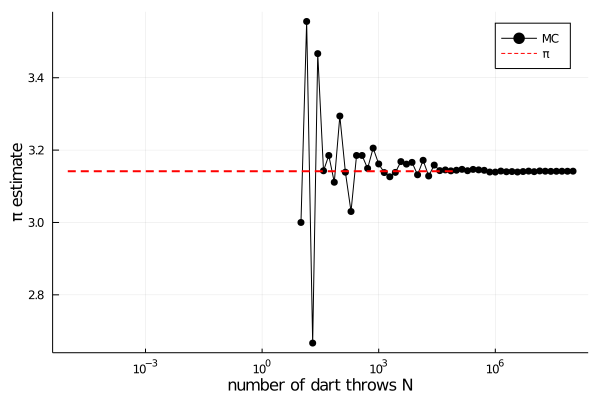

In [47]:
# 7)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))
@time pis = compute_pi_multiple_nested_parallel_spawn(Ns)

plot(Ns, pis, color=:black, marker=:circle, lw=1, label="MC", xscale=:log10)
plot!(x->π, label="π", xscale=:log10, linestyle=:dash, color=:red, lw=2)
ylabel!("π estimate")
xlabel!("number of dart throws N")